Импорт библиотек, функция set_seed() для воспроизводимости результатов, перенос вычислений на GPU

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
 
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

import random
import os

def set_seed(SEED):
    torch.manual_seed(SEED) 
    torch.cuda.manual_seed_all(SEED) 
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False 
    random.seed(SEED)
    np.random.seed(SEED) 
    os.environ['PYTHONHASHSEED'] = str(SEED)
    
if not torch.cuda.is_available():
    cuda = False
else:
    cuda = True

device = torch.device("cuda" if cuda else "cpu")
print(device)

cuda


Функция create_symb_dict() для создания словаря, создание словаря транскрипции pron, выделение номеров столбцов таблицы для транскрипций pron_cols

In [3]:
def create_symb_dict(df, cols):
    symb_dict = {}
    
    def add2dict(key):
        if key in symb_dict:
            symb_dict[key] += 1
        else:
            symb_dict[key] = 0
            
    for col in cols:
        for word in df[col]:
            j = 0
            while j < len(word) - 1:
                if word[j + 1] == '̃':
                    add2dict(word[j:(j + 2)])
                    j += 2
                elif word[j] == '(':
                    add2dict(word[j:(j + 3)])
                    j += 3
                else:
                    add2dict(word[j])
                    j += 1
                    
            if j < len(word):
                add2dict(word[j])
    return symb_dict

verbs_df = pd.read_excel("IrrVerbs(parsing).xlsx")
verbs_df.drop_duplicates(inplace=True)
verbs_df.dropna(inplace=True)

pron_dict = create_symb_dict(verbs_df, verbs_df.columns[1::2])
pron = sorted(pron_dict.keys())

pron_cols = [i for i in range(1, 14, 2)]

Класс векторизатора

In [6]:
class Vectorizer(object):
    def __init__(self, n_grams):
        """
        Аргументы:
            n_grams: алфавит
        """
        self.n_grams = n_grams
        
        self.emb = {char: i + 1 for i, char in enumerate(n_grams)}
        self.emb['0'] = 0
        self._voc_size = len(self.emb)

    def get_voc_size(self):
        return self._voc_size

    def vectorize(self, word, vec_size):
        """Векторное представление слова
        Аргументы:
            word: обрабатываемое слово
            size: размер векторного представления
        """
        tokens = []
        while word != '':
            if word[:3] in self.n_grams:
                tokens.append(word[:3])
                word = word[3:]
            elif word[:2] in self.n_grams:
                tokens.append(word[:2])
                word = word[2:]
            else:
                tokens.append(word[0])
                word = word[1:]  

        vec = np.zeros(vec_size, dtype=int)
        for i, char in enumerate(tokens):
            if char not in self.emb:
                print("Буквосочетания '{0}' нет в словаре".format(char))
                return None
            vec[i] = self.emb[char]
        return vec

Класс набора данных

In [7]:
class IrrVerbsDataset(Dataset):
    def __init__(self, verbs_df, vectorizer, test_size=0.1, seed=42):
        """
        Аргументы:
            verbs_df (pandas.DataFrame): набор данных
            vectorizer (WordsVectorizer): экземпляр векторизатора, 
                                          полученный на основе набора данных
        """
        self.verbs_df = verbs_df
        self._vectorizer = vectorizer

        self.test_df = self.verbs_df.sample(frac=test_size, random_state=seed)
        self.test_verbs_nums = sorted(list(self.test_df.index))
        self.test_size = len(self.test_df)

        self.train_df = self.verbs_df.drop(self.test_df.index)
        self.train_size = len(self.train_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

        self.max_word_size()

    def max_word_size(self):
        """Вычисление максимальной длины слова"""
        max_len = 0
        for col in self.verbs_df.columns:
            for i in self.verbs_df.index:
                if len(str(self.verbs_df[col][i])) > max_len:
                    max_len = len(self.verbs_df[col][i])
        self.word_size = max_len


    @classmethod
    def load_dataset(cls, verbs_table, cols, vectorizer, test_size=0.1, seed=42):
        """Загружает набор данных
        Аргументы:
            verbs_table: местоположение набора данных
        Возвращает:
            экземпляр IrrVerbsDataset
        """
        verbs_df = pd.read_excel(verbs_table, usecols=cols)
        verbs_df.drop_duplicates(inplace=True)
        verbs_df.dropna(inplace=True)
        return cls(verbs_df, vectorizer, test_size, seed)

    def set_split(self, split="train"):
        """Выбор фрагментов набора данных по столбцу из объекта dataframe
            split (str): "train"/"test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[self._target_split]

    def __getitem__(self, idx):
        row = self._target_df.iloc[idx]
        inf_vector = self._vectorizer.vectorize(row[0], self.word_size)
        form_vector = np.concatenate([self._vectorizer.vectorize(word, self.word_size) 
                                      for word in row[1:]])
        
        return {"inf": inf_vector,
                "form": form_vector}

    def __len__(self):
        return self._target_size

Функция-генератор мини-батчей generate_batches() и функция оценки точности compute_accuracy()

In [8]:
def generate_batches(dataset, batch_size, shuffle=True, 
                     drop_last=True, device="cpu"):
    """
        Функция-генератор - адаптер для объекта Dataloader фреймворка PyTorch.
        Гарантирует размещение всех тензоров на нужном устройстве.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, 
                            shuffle=shuffle, drop_last=drop_last)
    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict
        
def compute_accuracy(form_pred, form_real):
    form_real = form_real.cpu()
    form_pred = (torch.argmax(form_pred, 2)).cpu()
    n_correct = 0
    for i in range(len(form_real)):
        if all(form_pred[i] == form_real[i]):
            n_correct += 1
    return n_correct / len(form_real)

Класс модели GRU

In [9]:
class GRUInf2Form(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, num_forms=6):
        super(GRUInf2Form, self).__init__()
        self.hidden_dim = hidden_dim
        self.char_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, 
                          bidirectional=True, batch_first=True)
        self.hidden2tag = nn.ModuleList([nn.Linear(hidden_dim * 2, vocab_size) for _ in range(num_forms)])
 
    def forward(self, sentence):
        embeds = self.char_embeddings(sentence)
        gru_out, _ = self.gru(embeds)
        tag_space = [hidden2tag(gru_out) for hidden2tag in self.hidden2tag]
        return torch.cat(tag_space, dim=1)

Получение данных эксперимента по возможности обнаружения эффекта "гроккинга" (фиксированное значение lr).
После выполнения кода в ячейке данные экспериментов сохранятся в файлах.

In [ ]:
EMBEDDING_DIM = 16
HIDDEN_DIM = 32
BATCH_SIZE = 16
LEARN_RATE = 1.5
ITER = 92
EPOCH = 50000
SEED = 151

set_seed(SEED)

vectorizer = Vectorizer(pron)
dataset = IrrVerbsDataset.load_dataset("IrrVerbs(parsing).xlsx", pron_cols, vectorizer, seed=SEED)

model = GRUInf2Form(EMBEDDING_DIM, HIDDEN_DIM, vectorizer.get_voc_size())
model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARN_RATE)

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for _ in trange(ITER, desc='iter'):
    for epoch in trange(EPOCH, desc='epoch{}'.format(_ + 1)):
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, batch_size=BATCH_SIZE, 
                                           device=device)
        running_loss = 0.0
        running_acc = 0.0
        model.train()

        for idx, batch in enumerate(batch_generator):
            optimizer.zero_grad()

            form_pred = model(batch['inf'])
            loss = loss_func(form_pred.view(-1, form_pred.size(-1)), 
                             batch['form'].view(-1).to(torch.int64))
            loss_batch = loss.item()
            running_loss += (loss_batch - running_loss) / (idx + 1)
            acc_batch = compute_accuracy(form_pred, batch['form'])
            running_acc += (acc_batch - running_acc) / (idx + 1)
            loss.backward()
            optimizer.step()

        train_loss.append(running_loss)
        train_acc.append(running_acc)

        dataset.set_split('test')
        batch_generator = generate_batches(dataset, batch_size=BATCH_SIZE,
                                       shuffle=False, drop_last=False,
                                       device=device)
        running_loss = 0.0
        running_acc = 0.0
        model.eval()

        for idx, batch in enumerate(batch_generator):

            form_pred = model(batch['inf'])
            loss = loss_func(form_pred.view(-1, form_pred.size(-1)), 
                        batch['form'].view(-1).to(torch.int64))
            loss_batch = loss.item()
            running_loss += (loss_batch - running_loss) / (idx + 1)
            acc_batch = compute_accuracy(form_pred, batch['form'])
            running_acc += (acc_batch - running_acc) / (idx + 1)

        val_loss.append(running_loss)
        val_acc.append(running_acc)
        
    np.save('train_loss', train_loss)
    np.save('train_acc', train_acc)
    np.save('val_loss', val_loss)
    np.save('val_acc', val_acc)

Для получения данных эксперимента по возможности обнаружения эффекта "гроккинга" (циклическое изменение lr и оптимизатор AdamW) необходимо:

- установить параметр OPT_ADAMW (False для эксперимента с циклическим изменением lr, True для эксперимента с оптимизатором AdamW)

После выполнения кода в ячейке данные экспериментов сохранятся в файлах.

In [ ]:
EMBEDDING_DIM = 16
HIDDEN_DIM = 32
BATCH_SIZE = 16
LEARN_RATE = 1.
ITER = 200
EPOCH = 10000
SEED = 197
TEST_SIZE = 0.5
OPT_ADAMW = False

set_seed(SEED)

vectorizer = Vectorizer(pron)
dataset = IrrVerbsDataset.load_dataset("IrrVerbs(parsing).xlsx", pron_cols, vectorizer, 
                                       test_size=TEST_SIZE, seed=SEED)

model = GRUInf2Form(EMBEDDING_DIM, HIDDEN_DIM, vectorizer.get_voc_size())
model.to(device)
loss_func = nn.CrossEntropyLoss()

if OPT_ADAMW:
    optimizer = optim.AdamW(model.parameters(), weight_decay=1)
else:
    optimizer = optim.SGD(model.parameters(), lr=LEARN_RATE)
    scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=1.,
                                            max_lr=10., step_size_up=40,
                                            cycle_momentum=False)

train_loss = []
train_acc = []
val_loss = []
val_acc = []
norm_2_grad = []
norm_inf_grad = []

for _ in trange(ITER, desc='iter'):
    for epoch in trange(EPOCH, desc='epoch{}'.format(_ + 1)):
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, batch_size=BATCH_SIZE, 
                                           device=device)
        running_loss = 0.0
        running_acc = 0.0
        running_2_grad = 0.0
        running_inf_grad = 0.0
        model.train()

        for idx, batch in enumerate(batch_generator):
            optimizer.zero_grad()

            form_pred = model(batch['inf'])
            loss = loss_func(form_pred.view(-1, form_pred.size(-1)), 
                             batch['form'].view(-1).to(torch.int64))
            loss_batch = loss.item()
            running_loss += (loss_batch - running_loss) / (idx + 1)
            acc_batch = compute_accuracy(form_pred, batch['form'])
            running_acc += (acc_batch - running_acc) / (idx + 1)
            loss.backward()
            
            for i in model.parameters():
                running_2_grad += np.sum(np.array(i.grad.to('cpu')) ** 2)
                running_inf_grad = max(running_inf_grad, np.max(np.abs(np.array(i.grad.to('cpu')))))
                
            optimizer.step()
            if not OPT_ADAMW:
                scheduler.step()

        train_loss.append(running_loss)
        train_acc.append(running_acc)
        norm_2_grad.append(np.sqrt(running_2_grad))
        norm_inf_grad.append(running_inf_grad)

        dataset.set_split('test')
        batch_generator = generate_batches(dataset, batch_size=BATCH_SIZE,
                                       shuffle=False, drop_last=False,
                                       device=device)
        running_loss = 0.0
        running_acc = 0.0
        model.eval()

        for idx, batch in enumerate(batch_generator):

            form_pred = model(batch['inf'])
            loss = loss_func(form_pred.view(-1, form_pred.size(-1)), 
                        batch['form'].view(-1).to(torch.int64))
            loss_batch = loss.item()
            running_loss += (loss_batch - running_loss) / (idx + 1)
            acc_batch = compute_accuracy(form_pred, batch['form'])
            running_acc += (acc_batch - running_acc) / (idx + 1)

        val_loss.append(running_loss)
        val_acc.append(running_acc)
    
    checkpoint = {'state_dict': model.state_dict(), 
                  'optimizer': optimizer.state_dict(), 
                  'scheduler': scheduler.state_dict(), 
                  'train_loss': train_loss, 
                  'train_acc': train_acc, 
                  'val_loss': val_loss, 
                  'val_acc': val_acc, 
                  'norm_2_grad': norm_2_grad, 
                  'norm_inf_grad': norm_inf_grad}
    torch.save(checkpoint, 'checkpoint_{}_AdamW_wd1.pth'.format(EPOCH * (_ + 1)))

Для построения графиков точности модели, значения функции потерь от количества эпох обучения (рисунок 3.11) необходимо выполнить код 2 ячеек ниже.

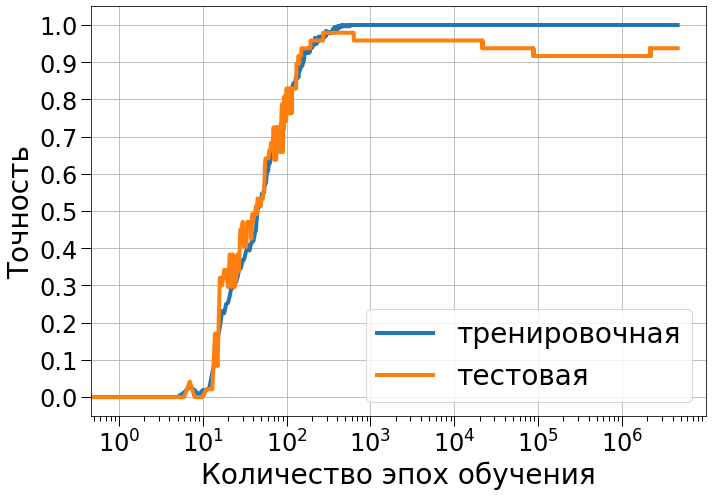

In [14]:
train_loss = np.load('train_loss.npy') 
train_acc = np.load('train_acc.npy') 
val_loss = np.load('val_loss.npy')
val_acc = np.load('val_acc.npy')

fig, ax = plt.subplots(figsize=(10, 7), )

ax.plot(train_acc, label='тренировочная', lw=4)
ax.plot(val_acc, label='тестовая', lw=4)
ax.legend(loc='lower right', fontsize=28)
ax.set_ylabel('Точность', fontsize=28)
ax.set_xlabel('Количество эпох обучения', fontsize=28)
ax.set_xscale('log')
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.tick_params(labelsize=24, length=10, width=1)
ax.tick_params(which='minor', length=5, width=1)
ax.grid(True)

fig.tight_layout()
plt.show()

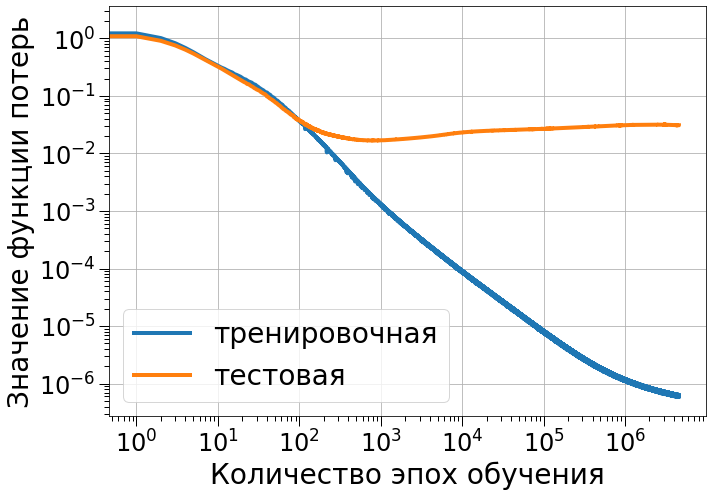

In [15]:
fig, ax = plt.subplots(figsize=(10, 7), )

ax.plot(train_loss, label='тренировочная', lw=4)
ax.plot(val_loss, label='тестовая', lw=4)
ax.legend(loc='lower left', fontsize=28)
ax.set_ylabel('Значение функции потерь', fontsize=28)
ax.set_xlabel('Количество эпох обучения', fontsize=28)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(labelsize=24, length=10, width=1)
ax.tick_params(which='minor', length=5, width=1)
ax.grid(True)

fig.tight_layout()
plt.show()

Для построения графиков точности модели, значения функции потерь и нормы градиента  от количества эпох обучения (рисунок 3.12) необходимо установить параметр 
- CHECKPOINT ('checkpoint_2000000.pth' для циклического изменения lr (рисунок 3.12 (а, в, д)) или 'checkpoint_2000000_AdamW_wd1.pth' для оптимизатора AdamW (рисунок 3.12 (б, г, е))

и выполнить код 4 ячеек ниже.

In [10]:
CHECKPOINT = 'checkpoint_2000000.pth' #'checkpoint_2000000_AdamW_wd1.pth'

checkpoint = torch.load(CHECKPOINT)
train_acc = checkpoint['train_acc']
train_loss = checkpoint['train_loss']
val_acc = checkpoint['val_acc']
val_loss = checkpoint['val_loss']
norm_2_grad = checkpoint['norm_2_grad']
norm_inf_grad = checkpoint['norm_inf_grad']

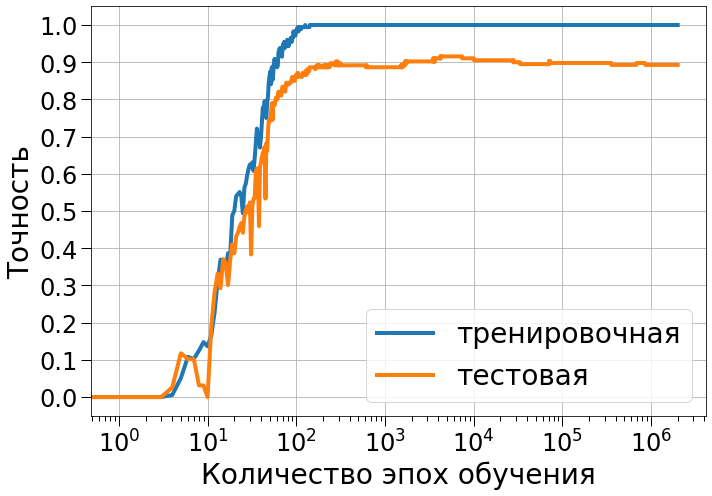

In [11]:
fig, ax = plt.subplots(1, figsize=(10, 7), )

ax.plot(train_acc, label='тренировочная', lw=4)
ax.plot(val_acc, label='тестовая', lw=4)
ax.set_ylabel('Точность', fontsize=28)
ax.set_xlabel('Количество эпох обучения', fontsize=28)
ax.set_xscale('log')
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.legend(loc='lower right', fontsize=28)
ax.tick_params(labelsize=24, length=10, width=1)
ax.tick_params(which='minor', length=5, width=1)
ax.grid(True)

fig.tight_layout()
plt.show()

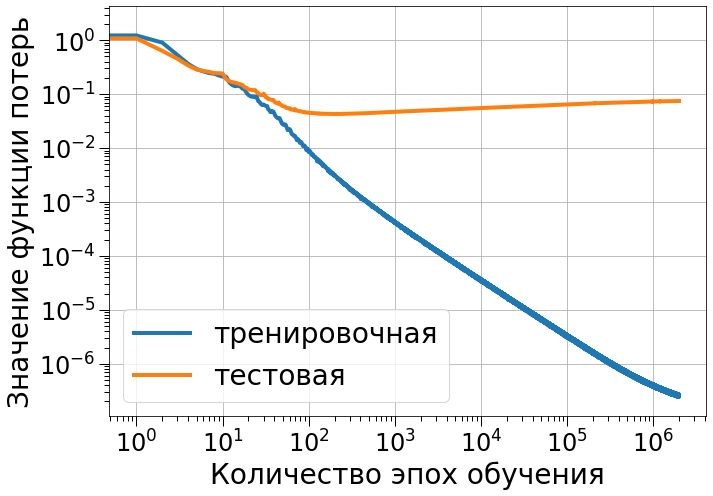

In [12]:
fig, ax = plt.subplots(1, figsize=(10, 7), )

ax.plot(train_loss, label='тренировочная', lw=4)
ax.plot(val_loss, label='тестовая', lw=4)
ax.set_ylabel('Значение функции потерь', fontsize=28)
ax.set_xlabel('Количество эпох обучения', fontsize=28)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='lower left', fontsize=28)
ax.tick_params(labelsize=24, length=10, width=1)
ax.tick_params(which='minor', length=5, width=1)
ax.grid(True)

fig.tight_layout()
plt.show()

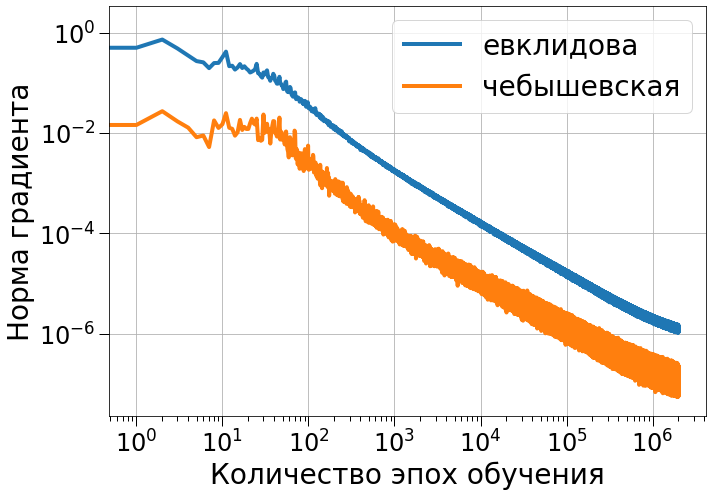

In [13]:
fig, ax = plt.subplots(1, figsize=(10, 7), )

ax.plot(norm_2_grad, label='евклидова', lw=4)
ax.plot(norm_inf_grad, label='чебышевская', lw=4)
ax.set_ylabel('Норма градиента', fontsize=28)
ax.set_xlabel('Количество эпох обучения', fontsize=28)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='upper right', fontsize=28)
ax.tick_params(labelsize=24, length=10, width=1)
ax.tick_params(which='minor', length=5, width=1)
ax.grid(True)

fig.tight_layout()
plt.show()